In [39]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [15]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((-1, 1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((-1, 1))

In [103]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 784, 1)
(12000, 1)
(1000, 784, 1)
(1000, 1)


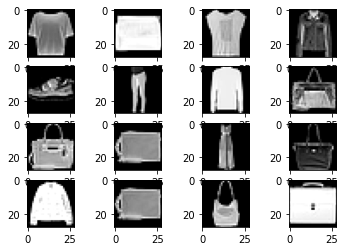

In [17]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(devxs))].reshape(28, 28))

In [13]:
loss = lambda y_pred, y: (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))
loss_prime = lambda y_pred, y: (y_pred - y) / (y_pred - (y_pred ** 2))

In [14]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) * (1 - sigmoid(x))

In [212]:
init_param = lambda shape: np.random.random(shape) / 100

class TwoLayerPerceptron():
    def __init__(self, Din, h):
        self.h = h
        self.Din = Din
        self.W1 = init_param((h, Din))
        self.b1 = init_param((h, 1))
        self.w2 = init_param((1, h))
        self.b2 = init_param((1, 1))
    
    def __str__(self):
        return str((self.W1, self.b1, self.w2, self.b2))
    
#     def forward(self, x):
#         cache = {}
#         cache["Z1"] = self.W1 @ X + self.b1
#         cache["A1"] = sigmoid(cache["Z1"])
#         cache["Z2"] = self.W2 @ cache["A1"] + self.b2
#         cache["A2"] = sigmoid(cache["Z2"])
        
#         return cache
    
#     def backward(self, x, y):
#         forward = self.forward(x)
#         dZ2 = loss_prime(forward["A2"], y)
        
#         # Final layer grads
#         dW2 = sigmoid_prime(dZ2)
#         db2 = sigmoid_prime
        
f = lambda m, x: sigmoid(m.w2.dot(sigmoid(m.W1 @ x + m.b1)) + m.b2)
p = lambda m, x: f(m, x) >= 0.5

mlp = TwoLayerPerceptron(784, 3)

In [213]:
def zero(m):
    gradm = TwoLayerPerceptron(m.Din, m.h)
    gradm.W1[:] = 0
    gradm.b1[:] = 0
    gradm.w2[:] = 0
    gradm.b2[:] = 0
    return gradm

def fprime(m, x, y, gradm=None):
    if gradm is None:
        gradm = zero(m)
    # Forward Pass
    z1 = m.W1 @ x + m.b1
    a1 = sigmoid(z1)
    z2 = m.w2.dot(a1) + m.b2
    y_pred = a2 = sigmoid(z2)
    
    # Backwards Pass
    error2 = y_pred - y

    gradm.b2 += error2
    gradm.w2 += error2 * a1.T
    
    da1 = (m.w2.T @ error2)
    dz1 = da1 * sigmoid_prime(z1)
    
    gradm.W1 += dz1 @ x.T
    gradm.b1 += np.sum(dz1)
    
    return gradm

In [214]:
def flatten(m):
    toFlatten = (m.W1, m.b1, m.w2, m.b2)
    vec = np.zeros(sum([x.size for x in toFlatten]))
    offset = 0
    for param in toFlatten:
#         print(param)
        vec[offset:offset + param.size] = param.flatten()
        offset += param.size
    return vec

def unflatten(m, vec):
    toFlatten = (m.W1, m.b1, m.w2, m.b2)
    offset = 0
    for param in toFlatten:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m
assert flatten(mlp).all() == flatten(unflatten(zero(mlp), flatten(mlp))).all()

In [215]:
def fdfprime(m, x, y, gradm=None):
    if gradm is None:
        gradm = zero(m)
    epsilon = 1e-6
    vecm = flatten(m)
    vecgradm = flatten(gradm)
    d(vecm.shape)
    d(vecm)
    for i in range(vecm.size):
        wi = vecm[i]
        
        vecm[i] += epsilon/2
        r = loss(f(unflatten(zero(m), vecm), x), y)
        vecm[i] = wi
        vecm[i] -= epsilon/2
        l = loss(f(unflatten(zero(m), vecm), x), y)
        vecgradm[i] = (r - l)/epsilon
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm)

In [216]:
somex = trainxs[5]
somey = trainys[5]
x = fprime(mlp, somex, somey)
y = fdfprime(mlp, somex, somey)

print(x, y)

(2359,)

array([0.00529034, 0.00960405, 0.00171648, ..., 0.00980775, 0.00194097,
       0.00363861])

(array([[-1.50717122e-05, -1.50717122e-05, -1.50717122e-05, ...,
        -1.50717122e-05, -1.50717122e-05, -1.50717122e-05],
       [-2.59083481e-05, -2.59083481e-05, -2.59083481e-05, ...,
        -2.59083481e-05, -2.59083481e-05, -2.59083481e-05],
       [-4.72921958e-06, -4.72921958e-06, -4.72921958e-06, ...,
        -4.72921958e-06, -4.72921958e-06, -4.72921958e-06]]), array([[-0.00051042],
       [-0.00051042],
       [-0.00051042]]), array([[-0.46861501, -0.46322231, -0.465831  ]]), array([[-0.49472648]])) (array([[-1.50714996e-05, -1.50714996e-05, -1.50714996e-05, ...,
        -1.50714996e-05, -1.50714996e-05, -1.50714996e-05],
       [-2.59081645e-05, -2.59081645e-05, -2.59081645e-05, ...,
        -2.59081645e-05, -2.59081645e-05, -2.59081645e-05],
       [-4.72910600e-06, -4.72910600e-06, -4.72910600e-06, ...,
        -4.72910600e-06, -4.72910600e-06, -4.72910600e-06]]), array([[-1.68300263e-04],
       [-2.89309021e-04],
       [-5.28096455e-05]]), array([[-0.46861501, -0.4632

In [44]:
np.sum(a, axis=1, keepdims=True)

array([[0.01663587]])

In [ ]:
# def accuracy(oidx, lidx, m):
#     correct = 0
#     for i in oidx:
#         p(m, data[[]])
# dfunction accuracy(oidx, lidx, m)
#     correct = 0
#     for i in oidx
#         p(m, data[["Mass", "Height"], i]) || continue
#         correct += 1
#     end
#     for i in lidx
#         !p(m, data[["Mass", "Height"], i]) || continue
#         correct += 1
#     end
#     correct/(length(oidx) + length(lidx))*100
# end

In [12]:
init_param((1, 5)) @ init_param((5))

array([0.000114])

In [ ]:
def back_propagate(X, Y, params, cache, m_batch):
    """
    back propagation

    inputs:
        params: dictionay a dictionary contains all the weights and biases
        cache: dictionay a dictionary contains all the fully connected units and activations

    return:
        grads: dictionay a dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer
    dZ2 = cache["A2"] - Y

    # gradients at last layer (Py2 need 1. to transform to float)
    dW2 = (1. / m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propgate through first layer
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))

    # gradients at first layer (Py2 need 1. to transform to float)
    dW1 = (1. / m_batch) * np.matmul(dZ1, X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads